In [241]:
import matplotlib.pyplot as plt
import scipy
import sympy
import numpy as np
import control 
import os
import array_to_latex as a2l
from LatexGapFiller import LatexGapFiller, TextSheet
from ControlTheoryToolbox import System, CToolbox
import cvxpy

In [242]:
def task1_get_G(specs):
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
        if new_g[i, i] == new_g[i-1, i-1]:
            new_g[i-1, i] = 1
    if specs[2].imag != 0:
        new_g[2, 2] = specs[2].real
        new_g[3, 3] = specs[2].real
        new_g[2, 3] = specs[2].imag
        new_g[3, 2] = -specs[2].imag
    return new_g

In [243]:
def task2_get_L(A, C, G, Y):
    Q = cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(G @ Q - Q @ A - Y @ C))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(Q.value)}')
    return np.linalg.pinv(Q.value) @ Y, Q.value

In [244]:
def task1_get_K(A, B, G, Y):
    P= cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(A @ P - P @ G - B @ Y))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(P.value)}')
    return - Y @ np.linalg.pinv(P.value), P.value

In [245]:
A = np.array([
    [3, -3, -5, 7],
    [-3, 3, -7, 5],
    [-5, -7, 3, 3],
    [7, 5, 3, 3],
])
B = np.array([
    [16],
    [12],
    [12],
    [12]
])
C = np.array([
    [3, -1, 1, 3],
    [-2, 2, 2, 2]
])
x0 = np.array([
    [10],
    [-10],
    [-10],
    [10]
])
xh0 = np.array([
    [2],
    [-2],
    [2],
    [-1]
])
print(a2l.to_ltx(A, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(B, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(C, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
   3  & -3  & -5  &   7 \\
 -3  &   3  & -7  &   5 \\
 -5  & -7  &   3  &   3 \\
   7  &   5  &   3  &   3 
\end{bmatrix}
\begin{bmatrix}
  16 \\
  12 \\
  12 \\
  12 
\end{bmatrix}
\begin{bmatrix}
   3  & -1  &   1  &   3 \\
 -2  &   2  &   2  &   2 
\end{bmatrix}


In [246]:
np.linalg.eig(A)[0]

array([-12.,   4.,  12.,   8.])

In [247]:
print(CToolbox.check_eigenvalues_controllable(A, B))
print(CToolbox.check_eigenvalues_observable(A, C))

[ True  True  True  True]
[False  True  True  True]


In [248]:
des_eigvalues = [-5, -5, -5, -5]
G = task1_get_G(des_eigvalues)
Y = np.array([[1, 0, 0, 0]])
G, Y

(array([[-5,  1,  0,  0],
        [ 0, -5,  1,  0],
        [ 0,  0, -5,  1],
        [ 0,  0,  0, -5]]),
 array([[1, 0, 0, 0]]))

In [249]:
print(a2l.to_ltx(G.astype(int), frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(Y, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
 -5  &   1  &   0  &   0 \\
   0  & -5  &   1  &   0 \\
   0  &   0  & -5  &   1 \\
   0  &   0  &   0  & -5 
\end{bmatrix}
\begin{bmatrix}
   1  &   0  &   0  &   0 
\end{bmatrix}


In [250]:
K, P =task1_get_K(A, B, G, Y)
K, P

Optimization error: 2.2187591664878084e-29, rankP = 4


(array([[-0.04447545, -7.70114397,  6.44202939, -1.34825149]]),
 array([[-6.05329311e-01,  1.46770319e-01, -2.26559195e-02,
          2.48227366e-03],
        [-5.71141277e-01,  1.87386873e-01, -1.53108243e-02,
          3.51625265e-03],
        [-3.17747612e-01,  2.21784203e-01, -1.17880811e-02,
          3.83880905e-03],
        [ 2.50578180e+00, -1.54871762e-02,  3.18778281e-02,
         -1.82447223e-03]]))

In [251]:
np.linalg.eig(A+B@K)[0]

array([-5.00261545+0.j        , -4.99999838+0.00261383j,
       -4.99999838-0.00261383j, -4.99738779+0.j        ])

In [252]:
def modeling(A, B, K, time_end = 3):
    ss = control.ss((A + B @ K), B*0, A * 0, B * 0)

    time = np.linspace(0, time_end, 1000)
    output = control.forced_response(ss, X0=[1, 1, 1, 1], T=time).states

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    colors = ['blue', 'r', 'green', 'orange']
    for i in range(4):
        axs[0].plot(time, output[i], linewidth=3, label=f"x_{i}(t)", color=colors[-i])
        # axs[i//2, i % 2].scatter(t[-1], x1[i], color='r', linewidth=4, label='goal')
    axs[0].set_title(f'x(t)', fontsize=12)
    axs[0].set_xlabel(f"t, [c]", fontsize=12)
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].plot(time, (K @ output).reshape(-1), linewidth=3, label=f"u(t)", color='r')
    axs[1].set_title(f'u(t)', fontsize=12)
    axs[1].set_xlabel(f"t, [c]", fontsize=12)
    axs[1].grid(True)
    axs[1].legend()

    # axs[1, 1].plot(t, np.array(U).reshape(-1), linewidth=4)
    # axs[1, 1].set_title(f'u = u(t)', fontsize=12)
    # axs[1, 1].set_xlabel(f"t, [c]", fontsize=12)
    # axs[1, 1].grid(True)

In [253]:
print(a2l.to_ltx(K, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
 -0.04 & -7.70 &  6.44 & -1.35
\end{bmatrix}


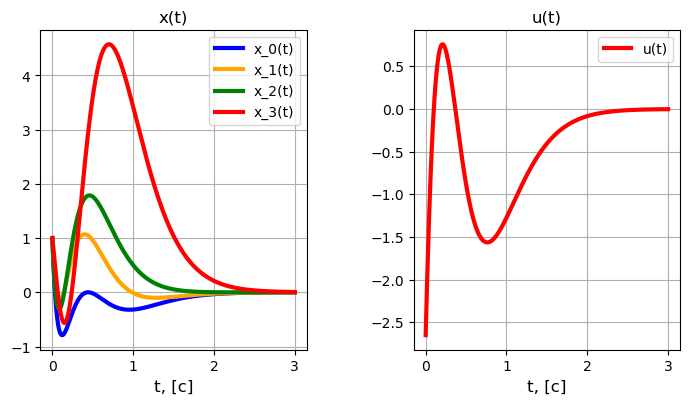

In [254]:
modeling(A, B, K)

In [255]:
def task2_simulate(A, C, L, x0, xh0, time_end):
    ts = np.linspace(0, time_end, 1000)
    ss_orig = control.ss(A, np.zeros((A.shape[0], 1)), C, np.zeros((C.shape[0], 1)))
    original_resp = control.forced_response(ss_orig, X0=x0, T=ts)
    ss = control.ss(A + L@C, -L, A*0, L*0)
    return ts, original_resp, control.forced_response(ss, X0=xh0, T=ts, U=original_resp.outputs.reshape(-1))

In [256]:
desired_eigvalues = [-12, -5, -5, -5]
print(a2l.to_ltx(np.array(desired_eigvalues), frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
G = task1_get_G(desired_eigvalues)
Y = np.array([
    [0, 0],
    [0, 0],
    [0, 0],
    [1, 1]
])
G, Y

\begin{bmatrix}
 -12  & -5  & -5  & -5 
\end{bmatrix}


(array([[-12,   0,   0,   0],
        [  0,  -5,   1,   0],
        [  0,   0,  -5,   1],
        [  0,   0,   0,  -5]]),
 array([[0, 0],
        [0, 0],
        [0, 0],
        [1, 1]]))

In [257]:
np.linalg.eig(G)[0]

array([-12.,  -5.,  -5.,  -5.])

In [258]:
CToolbox.check_eigenvalues_controllable(G, Y, method='jordan_form')

jordan_form  [0 0 0 1 0 0 0 1]


array([False,  True])

In [259]:
print(a2l.to_ltx(G.astype(int), frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(Y, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
 -12  &   0  &   0  &   0 \\
   0  & -5  &   1  &   0 \\
   0  &   0  & -5  &   1 \\
   0  &   0  &   0  & -5 
\end{bmatrix}
\begin{bmatrix}
   0  &   0 \\
   0  &   0 \\
   0  &   0 \\
   1  &   1 
\end{bmatrix}


In [260]:
L, Q = task2_get_L(A, C, G, Y)
L

Optimization error: 1.0846013660347856e-31, rankP = 3


array([[-18.37109375, -18.37109375],
       [-58.39453125, -58.39453125],
       [ 52.69921875,  52.69921875],
       [-24.06640625, -24.06640625]])

In [261]:
print(a2l.to_ltx(L, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
 -18.37 & -18.37\\
 -58.39 & -58.39\\
  52.70 &  52.70\\
 -24.07 & -24.07
\end{bmatrix}


In [262]:
np.linalg.eig(A+L@C)[0]

array([-12.        +0.j        ,  -4.99988413+0.00020071j,
        -4.99988413-0.00020071j,  -5.00023173+0.j        ])

In [263]:
task3_new_A = np.block([[A, B @ K],[-L@C, A+B@K+L@C]])
task3_new_A

array([[   3.        ,   -3.        ,   -5.        ,    7.        ,
          -0.71160714, -123.21830357,  103.07247024,  -21.57202381],
       [  -3.        ,    3.        ,   -7.        ,    5.        ,
          -0.53370536,  -92.41372768,   77.30435268,  -16.17901786],
       [  -5.        ,   -7.        ,    3.        ,    3.        ,
          -0.53370536,  -92.41372768,   77.30435268,  -16.17901786],
       [   7.        ,    5.        ,    3.        ,    3.        ,
          -0.53370536,  -92.41372768,   77.30435268,  -16.17901786],
       [  18.37109375,   18.37109375,   55.11328125,   91.85546875,
         -16.08270089, -144.58939732,   42.95918899, -106.42749256],
       [  58.39453125,   58.39453125,  175.18359375,  291.97265625,
         -61.92823661, -147.80825893, -104.87924107, -303.15167411],
       [ -52.69921875,  -52.69921875, -158.09765625, -263.49609375,
          47.16551339,  -46.71450893,  238.40200893,  250.31707589],
       [  24.06640625,   24.06640625,   7

In [264]:
np.concatenate((x0, xh0), axis=0)

array([[ 10],
       [-10],
       [-10],
       [ 10],
       [  2],
       [ -2],
       [  2],
       [ -1]])

In [265]:
np.concatenate((C, C), axis=1)

array([[ 3, -1,  1,  3,  3, -1,  1,  3],
       [-2,  2,  2,  2, -2,  2,  2,  2]])

In [266]:
def task2_simulate(A, B, C, K, L, x0, xh0, time_end):
    ts = np.linspace(0, time_end, 1000)
    new_A = np.block([[A, B @ K],[-L@C, A+B@K+L@C]])
    new_C = np.block([
        [C, np.zeros_like(C)],
        [np.zeros_like(C), C]
    ])
    ss = control.ss(new_A, np.zeros((new_A.shape[0], 1)), new_C, np.zeros((new_C.shape[0], 1)))
    original_resp = control.forced_response(ss, X0=np.concatenate((x0, xh0), axis=0), T=ts)
    # ss = control.ss(A + B@K + L@C, -L, C, np.zeros((C.shape[0], L.shape[1])))
    # print()
    return ts, original_resp

In [267]:
ts, res = task2_simulate(A, B, C, K, L, x0, xh0, 10.0)

In [268]:
K@res.states[4:]

array([[ 2.95456473e+01, -1.03714570e+02, -1.84060458e+02,
        -2.20981698e+02, -2.22980307e+02, -1.97628246e+02,
        -1.51625542e+02, -9.08582927e+01, -2.04560239e+01,
         5.51520259e+01,  1.32182069e+02,  2.07442659e+02,
         2.78283551e+02,  3.42546690e+02,  3.98519487e+02,
         4.44890442e+02,  4.80707202e+02,  5.05337052e+02,
         5.18429866e+02,  5.19883484e+02,  5.09811477e+02,
         4.88513257e+02,  4.56446455e+02,  4.14201504e+02,
         3.62478339e+02,  3.02065117e+02,  2.33818885e+02,
         1.58648078e+02,  7.74967680e+01, -8.66945061e+00,
        -9.88760224e+01, -1.92150546e+02, -2.87532534e+02,
        -3.84081910e+02, -4.80886340e+02, -5.77067475e+02,
        -6.71786198e+02, -7.64246959e+02, -8.53701260e+02,
        -9.39450389e+02, -1.02084744e+03, -1.09729874e+03,
        -1.16826466e+03, -1.23325995e+03, -1.29185365e+03,
        -1.34366853e+03, -1.38838025e+03, -1.42571620e+03,
        -1.45545402e+03, -1.47741997e+03, -1.49148709e+0

In [269]:
def modeling(res, ts):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    # colors = ['blue', 'r', 'green', 'orange']
    for i in range(2):
        ss = control.ss(A + L@C, L*0, A*0, L*0)
        original_resp = control.forced_response(ss, X0=x0-xh0, T=ts)
        # original_resp
        # res
        print(i//2, i%2)
        axs[i % 2].plot(ts, (C@res.states[:4])[i], linewidth=3, label=f"system", color='blue')
        # axs[i % 2].plot(ts, res.outputs[i+2], linewidth=3, linestyle='--',label=f"observer", color='red')
        axs[i % 2].plot(ts, (C@res.states[4:])[i], linewidth=3, linestyle='-.', label=f"observer", color='red')
        # axs[i // 2, i % 2].plot(ts, res.states[i] - res.states[i+4], linewidth=2, linestyle='--', label=f"error", color='orange')
        axs[i % 2].set_title(f'y_{i}(t)', fontsize=12)
        axs[i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i % 2].grid(True)
        axs[i % 2].legend()
    
    # axs[1].plot(time, (K @ output).reshape(-1), linewidth=3, label=f"u(t)", color='r')
    # axs[1].set_title(f'u(t)', fontsize=12)
    # axs[1].set_xlabel(f"t, [c]", fontsize=12)
    # axs[1].grid(True)
    # axs[1].legend()

    # axs[1, 1].plot(t, np.array(U).reshape(-1), linewidth=4)
    # axs[1, 1].set_title(f'u = u(t)', fontsize=12)
    # axs[1, 1].set_xlabel(f"t, [c]", fontsize=12)
    # axs[1, 1].grid(True)

0 0
0 1


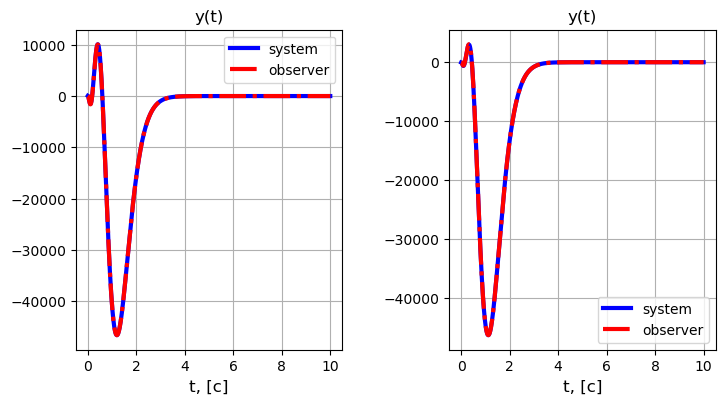

In [270]:
modeling(res, ts)